# Fitting A Gaussian to a Spectral Line

In this notebook we will follow a sample workflow of a scientist trying to produce a timeseries of a spectral line's intensity.  In doing so we will learn the following skills:
1. Open a FITS file and access the data within using astropy.io.fits
2. Plot data using matplotlib
3. Extract data from an array using numpy logical functions
4. Fit a Gaussian fo data using astropy models and fitting
5. Integrate using scipy.integrate
6. Use astropy quantities to associate units with our data

In [1]:
# Imports
import os.path
from datetime import datetime, timedelta

import numpy as np
from astropy.io import fits
from astropy.modeling import models, fitting
import matplotlib.pyplot as plt
from scipy.integrate import trapz
import astropy.units as u
from astropy.units import Quantity

In [2]:
# Activate option that plots windows in notebook
% matplotlib inline

## Extract Data from a FIT File

In [3]:
# Define filename
filename = 'EVS_L2_2011045_01_005_01.fit'

In [4]:
# Open FITS file with astropy.io.fits
hdulist = fits.open(filename)

The above command has created a list, hdulist, of Header Data Units (HDUs) which make up the FITS file.  Let us inspect this list.

In [5]:
# How many HDU are in hdulist?
len(hdulist)

4

This is an EVE level 2 spectrum file.  So the first HDU contain a minimal header and no data.

In [6]:
hdulist[0].header

SIMPLE  =                    T /Dummy Created by MWRFITS v1.11                  
BITPIX  =                    8 /Dummy primary header created by MWRFITS         
NAXIS   =                    0 /No data is associated with this header          
EXTEND  =                    T /Extensions may (will!) be present               

In [7]:
hdulist[0].data

The first wavelength data is contained in the 2nd HDU and the irradiance data is in the 4th HDU.  The data within these HDUs are stored in numpy record arrays, arrays where you can index the columns with a string.  So we can access the wavelength and irradiance data like so"

In [8]:
hdulist[1].data["WAVELENGTH"]

array([   3.00999999,    3.02999997,    3.04999995, ...,  106.94999695,
        106.97000122,  106.98999786], dtype=float32)

In [9]:
hdulist[3].data[0]["IRRADIANCE"]

array([-1., -1., -1., ..., -1., -1., -1.], dtype=float32)

## Plot A Spectrum

For this we will use the matplolib.pyplot package which we imported at the top and this notebook as plt.

(5, 40)

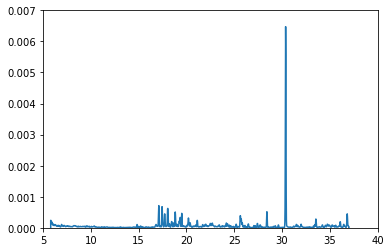

In [10]:
plt.plot(hdulist[1].data["WAVELENGTH"], hdulist[3].data[0]["IRRADIANCE"])
plt.ylim(0, 0.007) # Set limits of y-axis.
plt.xlim(5, 40) # Set limits of x-axis.

## Extract a Sub-region Around the He II 304 line.

We can see the strong He II 304.  Let us extract just the data around this line using the numpy logical and function.

In [11]:
w = np.logical_and(hdulist[1].data["WAVELENGTH"] > 30.2, hdulist[1].data["WAVELENGTH"] < 30.6)

This produces an array of boolean values of the same shape as the array we searched, i.e. hdulist[1].data["WAVELENGTH"].  True values show elements in the original array that meet our criteria and False for those that don't.

In [12]:
w

array([False, False, False, ..., False, False, False], dtype=bool)

We can use this boolean array to index our data array and extract just the data around the He II 304 line.

In [13]:
wavelength = hdulist[1].data["WAVELENGTH"][w] # Wavelength around the He II 304 line
irradiance = hdulist[3].data[0]["IRRADIANCE"][w] # Irradiance from first exposure around the He II 304 line

In [14]:
wavelength

array([ 30.20999908,  30.22999954,  30.25      ,  30.27000046,
        30.29000092,  30.30999947,  30.32999992,  30.35000038,
        30.37000084,  30.38999939,  30.40999985,  30.43000031,
        30.45000076,  30.46999931,  30.48999977,  30.51000023,
        30.53000069,  30.54999924,  30.56999969,  30.59000015], dtype=float32)

In [15]:
irradiance

array([  1.17592981e-05,   1.35788505e-05,   1.46737157e-05,
         4.38078278e-05,   1.87091311e-04,   6.48452318e-04,
         2.21259100e-03,   4.76356782e-03,   6.47498108e-03,
         5.55816106e-03,   3.01268930e-03,   1.03060238e-03,
         2.30668578e-04,   8.90922092e-05,   6.03179433e-05,
         5.12264814e-05,   4.05171013e-05,   3.55092270e-05,
         3.55048214e-05,   3.37863094e-05], dtype=float32)

To avoid confusion, we can associate the data with a unit by using astropy Quantities (imported at start of notebook).  This will also allow us to easily convert between units and perform unit arithmetic.  We can define units using strings or astropy unit objects (imported above).

In [16]:
wavelength = Quantity(wavelength, unit=u.nm) # EVE wavelength data supplied as nm.  Unit defined using unit object.
irradiance = Quantity(irradiance, unit="W/m**2") # Unit supplied as string.

Let us plot this truncated data.

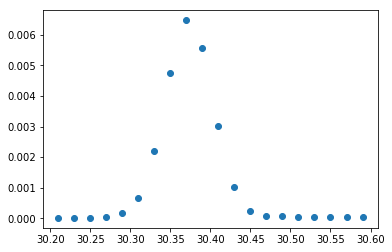

In [17]:
plt.plot(wavelength, irradiance, 'o') # The 'o' input sets the linestyle as filled circles

## Fit He II 304 line with a Gaussian

In [18]:
# Define a Gaussian model as an initial guess of the best fit.
g_init = models.Gaussian1D(amplitude=0.007, mean=30.4, stddev=0.2)

In [19]:
# Select and instantiate the type of fitting algorithm we want to use 
# from the fitting module of astropy.modeling package.
fit_g = fitting.LevMarLSQFitter()

In [20]:
# Fit the data
g = fit_g(g_init, wavelength, irradiance)

The above command creates an object containing the best fit paramters to the data for the model we have chosen to fit.  We can inspect the values of the different paramters like so.

In [21]:
g.amplitude

Parameter('amplitude', value=0.006512233582758824)

In [22]:
g.mean

Parameter('mean', value=30.373349145178118)

In [23]:
g.stddev

Parameter('stddev', value=0.029547785343013666)

And we can produce best fit y-values for any x-value like so:

In [28]:
x = np.linspace(30.2, 30.6, 1000)*u.nm

In [29]:
y = g(x)

Now lets overplot the fit on the data.  Let's also add labels to the axes

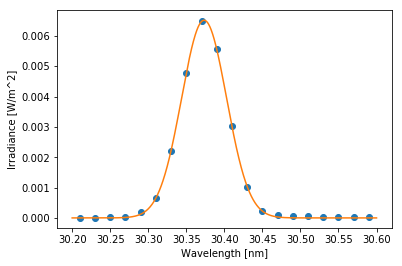

In [30]:
plt.plot(wavelength, irradiance, 'o')
plt.plot(x, y)
plt.ylabel("Irradiance [W/m^2]")
plt.xlabel("Wavelength [nm]")

We can also easily change the units of the data and replot

In [31]:
x = Quantity(x, unit="nm")
y = Quantity(y, unit=u.W/u.m**2)

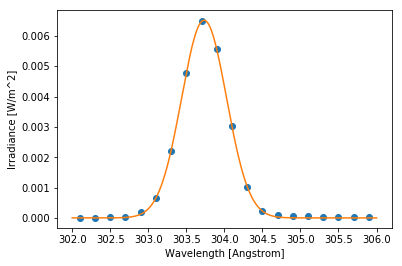

In [32]:
plt.plot(wavelength.to(u.angstrom), irradiance, 'o')
plt.plot(x.to(u.angstrom), y)
plt.ylabel("Irradiance [W/m^2]")
plt.xlabel("Wavelength [Angstrom]")

## Integrate Gaussian Fit

We can perform trapezoidal numerical integration of the fit using scipy.stats.trapz function (imported above).

In [33]:
line_intensity = trapz(y,x)

In [34]:
line_intensity

<Quantity 0.00048233062533621857 nm W / m2>

Note that the unit arithmetic has been automatically accounted for.  We can put the units is a cleaner form (and alter the data accordinly by doing:)

In [35]:
line_intensity = line_intensity.to("W/m")

We can also convert the Quantity to CGS or SI like so.

In [36]:
line_intensity.cgs
# N.B. this returns a new object.  To overwrite line_intensity with CGS version, do line_intensity = line_intensity.cgs

<Quantity 4.8233062533621855e-08 dyn / s>

In [37]:
line_intensity.si
# N.B. this returns a new object.  To overwrite line_intensity with SI version, do line_intensity = line_intensity.si

<Quantity 4.823306253362186e-13 W / m>

## Produce a Light Curve of He II 304 From All Spectra in File.

Let's Repeat this process for all exposures in order to produce a timeseries of the He II 304 line.

In [38]:
x = np.linspace(30.2, 30.6, 1000)*u.nm
# Define empty list
intensity = []
# Get wavelengths corresponding to He II 304 line
w = np.logical_and(hdulist[1].data["WAVELENGTH"] > 30.2, hdulist[1].data["WAVELENGTH"] < 30.6)
wavelength = Quantity(hdulist[1].data["WAVELENGTH"][w], "nm")
# For each exposure, get irradiance of He II 304 line, fit it with a Gaussian and integrate it.
for spectrum in hdulist[3].data:
    irradiance = Quantity(spectrum["IRRADIANCE"][w], unit="W/m**2")
    g_init = models.Gaussian1D(0.007, 30.4, .2)
    fit_g = fitting.LevMarLSQFitter()
    g = fit_g(g_init, wavelength, irradiance)
    y = g(x)
    intensity.append(trapz(y,x))
intensity = Quantity(intensity, unit="W/m")

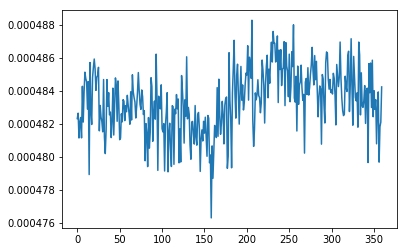

In [39]:
plt.plot(intensity)